# Homework 02: Multi-Class Classification with Neural Networks

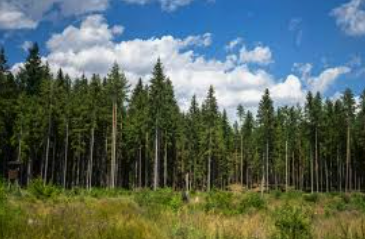

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [3]:
# Useful imports

%pip install pandas
%pip install matplotlib seaborn
%pip install scikit-learn matplotlib seaborn 
!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages 


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


2026-02-05 23:17:16.026994: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-05 23:17:35.236882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 23:17:43.973744: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


$$k\cdot\sigma$$

In [4]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}') 

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [5]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub)) 


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [6]:
# Your code here

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
random_seed = 42


# 1) Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub,
    test_size=0.2,
    random_state=random_seed,
    stratify=y_sub
)

# 2) Standardize features (fit on train only!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print("Train shape:", X_train.shape, Counter(y_train))
print("Test shape: ", X_test.shape, Counter(y_test)) 

Train shape: (15383, 54) Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197})
Test shape:  (3846, 54) Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Epoch 1/20


2026-02-05 23:17:46.291417: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3519 - loss: 1.6930
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5482 - loss: 1.2413
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5866 - loss: 1.0385
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6219 - loss: 0.9435
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6445 - loss: 0.8881
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6625 - loss: 0.8499
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6730 - loss: 0.8210
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6817 - loss: 0.7977
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6879 - loss: 0.7781
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6935 - loss: 0.7614
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6975 - loss: 0.7469
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy

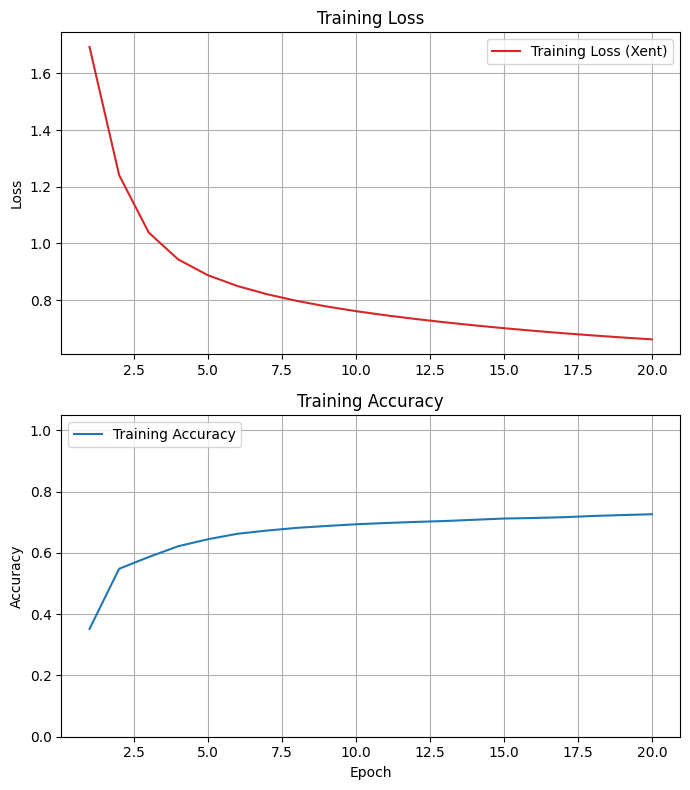

Final Training Loss:     0.6619
Final Training Accuracy: 0.7262


In [7]:
# Your code here

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 

# Build the model: input -> 64 -> 32 -> output(7)
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train (20 epochs, batch_size=32)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate training (plots + final metrics printout)
plot_history(history) 

In [8]:
# Set a1a to the final training accuracy at epoch 20

a1a = 0.7285 

In [9]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7285


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


===== Training with batch_size = 4 =====
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4904 - loss: 1.3615
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6339 - loss: 0.8941
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6651 - loss: 0.8076
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6877 - loss: 0.7625
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7006 - loss: 0.7287
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7144 - loss: 0.7014
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7253 - loss: 0.6783
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7311 - loss: 0.6592
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7372 - loss: 0.6432
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7400 - loss: 0.6295
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7445 - l

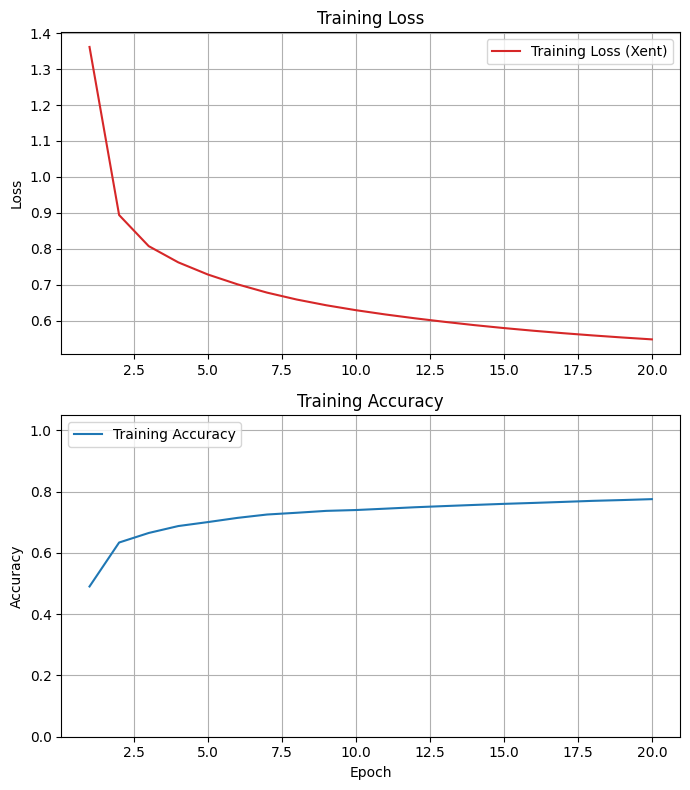

Final Training Loss:     0.5483
Final Training Accuracy: 0.7755

===== Training with batch_size = 8 =====
Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4664 - loss: 1.4074
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6172 - loss: 0.9380
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6577 - loss: 0.8318
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6800 - loss: 0.7801
Epoch 5/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6913 - loss: 0.7454
Epoch 6/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6998 - loss: 0.7192
Epoch 7/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7081 - loss: 0.6987
Epoch 8/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7161 - loss: 0.6818
Epoch 9/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7220 - loss: 0.6675
Epoch 10/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7272 - loss: 0.6549
Epoch 11/20
1

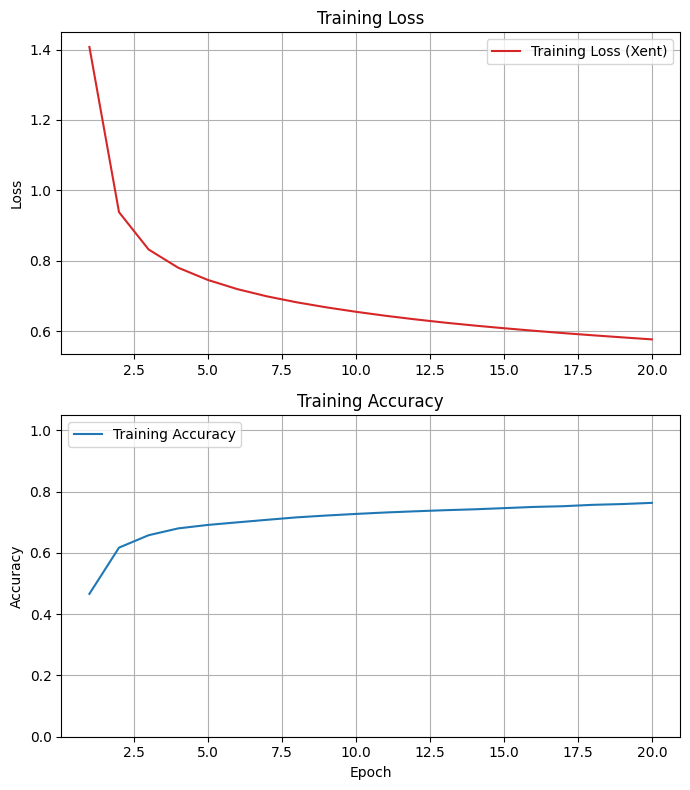

Final Training Loss:     0.5764
Final Training Accuracy: 0.7634

===== Training with batch_size = 16 =====
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4369 - loss: 1.6014
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6068 - loss: 1.0657
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6375 - loss: 0.9010
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6555 - loss: 0.8376
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6726 - loss: 0.8004
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6854 - loss: 0.7736
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6960 - loss: 0.7523
Epoch 8/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7046 - loss: 0.7346
Epoch 9/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7105 - loss: 0.7189
Epoch 10/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7149 - loss: 0.7052
Epoch 11/20
962/962 ━━━━━━━━━━━━

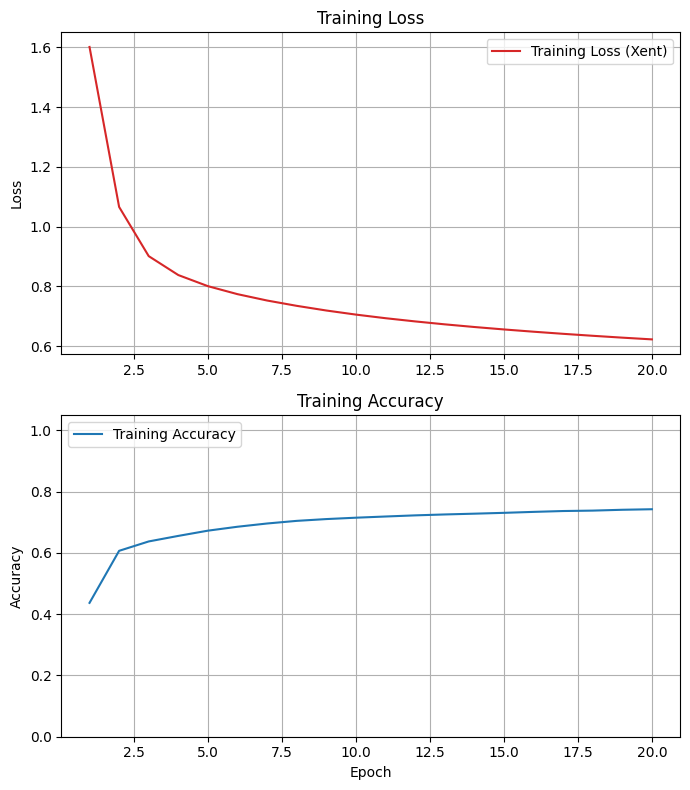

Final Training Loss:     0.6222
Final Training Accuracy: 0.7426

===== Training with batch_size = 128 =====
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1473 - loss: 2.0140
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3468 - loss: 1.7814
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4659 - loss: 1.5893
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5259 - loss: 1.4166
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5555 - loss: 1.2648
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5726 - loss: 1.1482
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5882 - loss: 1.0658
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6024 - loss: 1.0070
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6135 - loss: 0.9633
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 0.9296
Epoch 11/20
121/121 ━━━━━━━━━━━

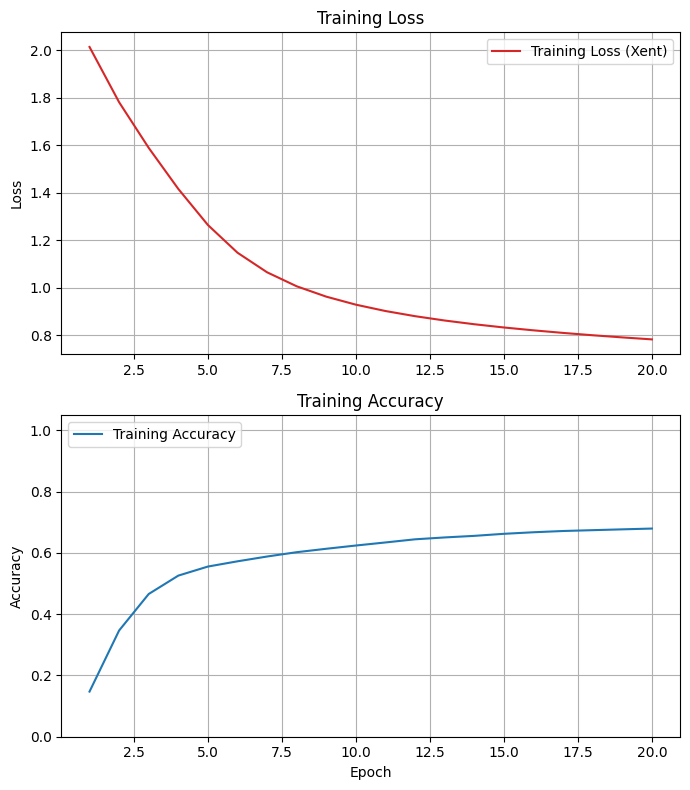

Final Training Loss:     0.7836
Final Training Accuracy: 0.6795


In [10]:
# Your code here

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

batch_sizes = [4, 8, 16, 128]
histories = {}   

for bs in batch_sizes:
    tf.keras.backend.clear_session()  

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile (same as Problem 1)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n===== Training with batch_size = {bs} =====")
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=bs,
        verbose=1
    )

    histories[bs] = history
    plot_history(history)


In [11]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = 4

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [13]:
# Set a2b to the best accuracy score found

a2b = 0.7780 

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7780


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



===== Training with learning_rate = 0.001 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5929 - loss: 1.0295
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6976 - loss: 0.7334
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7211 - loss: 0.6673
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7369 - loss: 0.6270
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7506 - loss: 0.5979
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7617 - loss: 0.5756
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7679 - loss: 0.5577
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7738 - loss: 0.5428
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7793 - loss: 0.5300
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7835 - loss: 0.5191
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7876 - loss: 0.5099
Epo

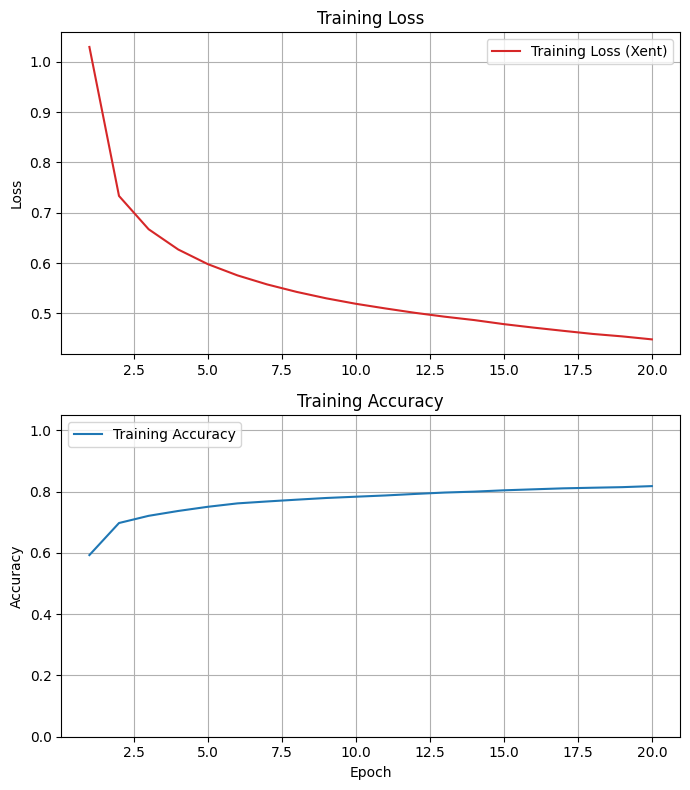

Final Training Loss:     0.4484
Final Training Accuracy: 0.8180

===== Training with learning_rate = 0.0005 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5451 - loss: 1.1728
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6644 - loss: 0.8139
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6989 - loss: 0.7407
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7164 - loss: 0.6933
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7296 - loss: 0.6586
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7420 - loss: 0.6328
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7502 - loss: 0.6115
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7569 - loss: 0.5941
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7617 - loss: 0.5790
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7671 - loss: 0.5663
Epoch 11/20
481/481 ━━━━━

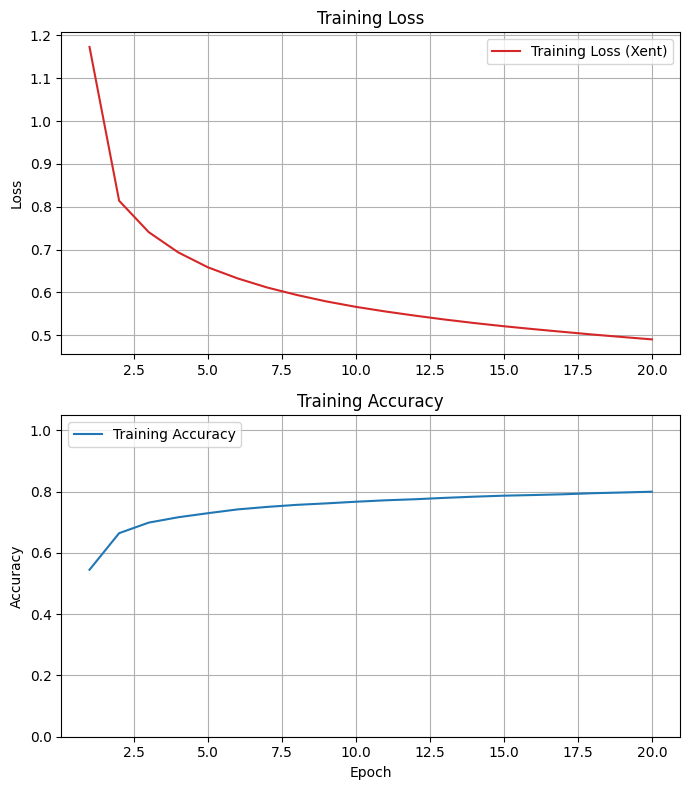

Final Training Loss:     0.4904
Final Training Accuracy: 0.7998

===== Training with learning_rate = 0.0001 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3430 - loss: 1.7863
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5376 - loss: 1.2788
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5975 - loss: 1.0240
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6332 - loss: 0.9171
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6529 - loss: 0.8603
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6678 - loss: 0.8247
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6778 - loss: 0.7991
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6868 - loss: 0.7788
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6936 - loss: 0.7615
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6982 - loss: 0.7463
Epoch 11/20
481/481 ━━━━━

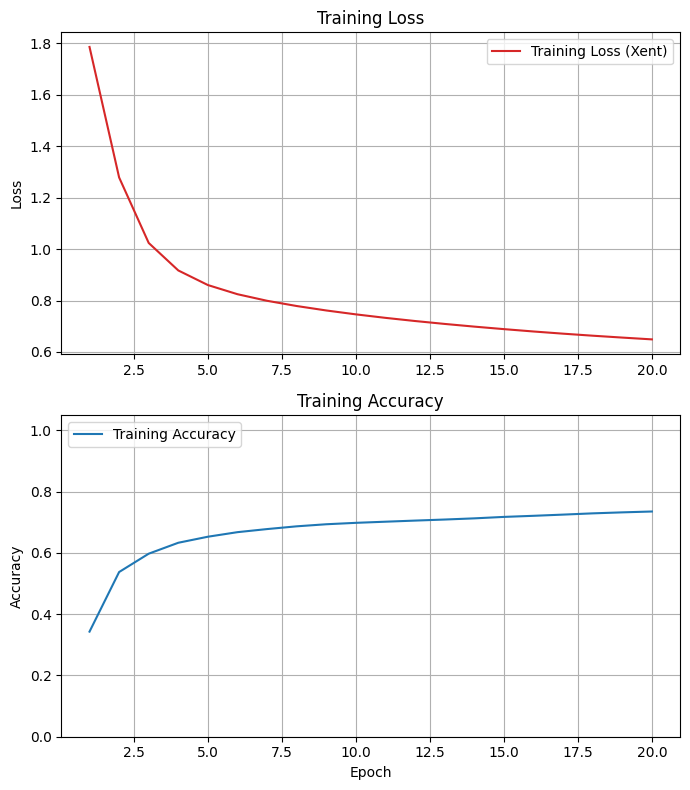

Final Training Loss:     0.6491
Final Training Accuracy: 0.7352

===== Training with learning_rate = 5e-05 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2353 - loss: 1.8818
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4513 - loss: 1.5731
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5368 - loss: 1.3420
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5683 - loss: 1.1750
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5827 - loss: 1.0654
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5985 - loss: 0.9949
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6107 - loss: 0.9472
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6228 - loss: 0.9125
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6350 - loss: 0.8857
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6440 - loss: 0.8642
Epoch 11/20
481/481 ━━━━━━

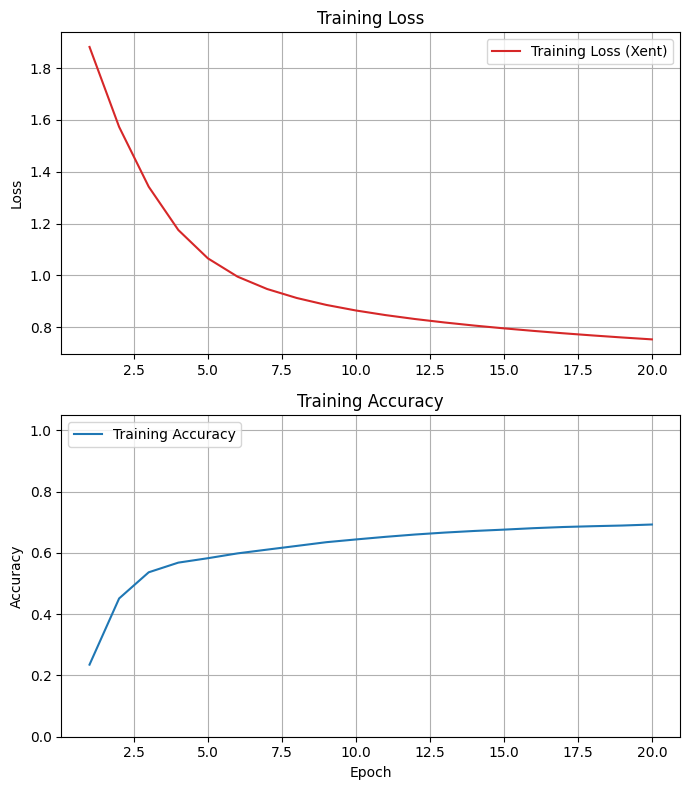

Final Training Loss:     0.7527
Final Training Accuracy: 0.6927

===== Training with learning_rate = 1e-05 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1819 - loss: 1.9776
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2343 - loss: 1.8983
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2912 - loss: 1.8273
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3388 - loss: 1.7627
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3752 - loss: 1.7032
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4103 - loss: 1.6476
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4446 - loss: 1.5948
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4712 - loss: 1.5444
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4941 - loss: 1.4962
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5108 - loss: 1.4502
Epoch 11/20
481/481 ━━━━━━

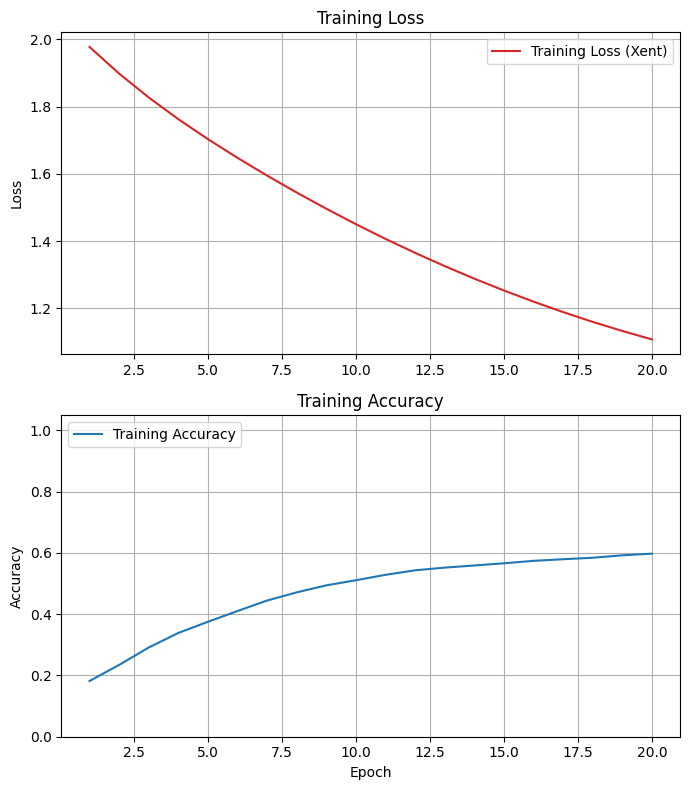

Final Training Loss:     1.1074
Final Training Accuracy: 0.5976


In [15]:
# Your code here

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
lr_histories = {}

for lr in learning_rates:
    tf.keras.backend.clear_session()  # fresh model each run

    # Build (same architecture as Problem One)
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile with varying learning rate
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n===== Training with learning_rate = {lr} =====")
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,   # same as baseline
        verbose=1
    )

    lr_histories[lr] = history
    plot_history(history)




In [16]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = 1e-3 

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [18]:
# Set a3b to the accuracy found by the best learning rate

a3b = 0.8276 

In [19]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8276


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


===== CosineDecay with initial_learning_rate = 0.01 =====
Epoch 1/20


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6593 - loss: 0.8167
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7186 - loss: 0.6732
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7374 - loss: 0.6391
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7532 - loss: 0.5967
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7628 - loss: 0.5769
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7729 - loss: 0.5446
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7822 - loss: 0.5219
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7956 - loss: 0.4978
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8078 - loss: 0.4695
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8147 - loss: 0.4485
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8251 - loss: 0.4263
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy

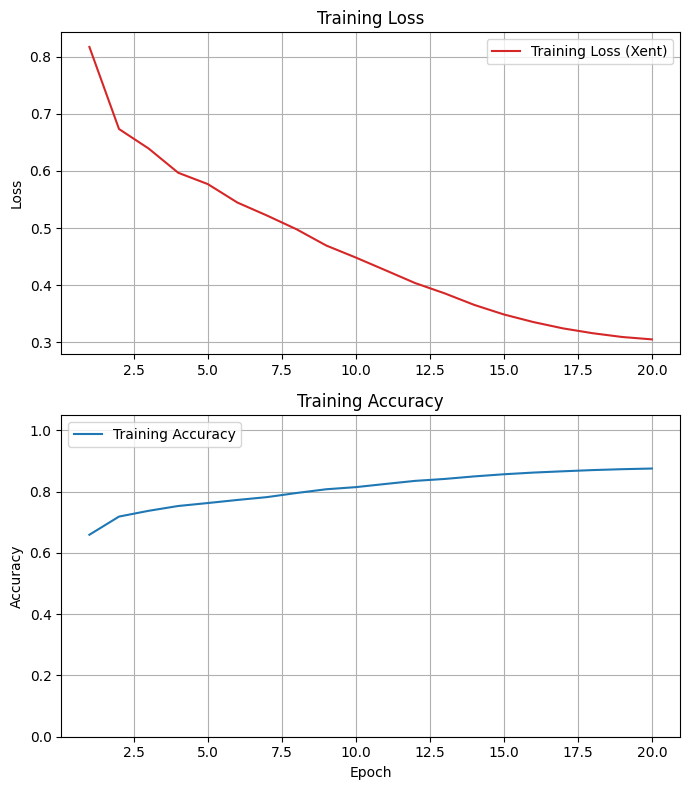

Final Training Loss:     0.3054
Final Training Accuracy: 0.8754

===== CosineDecay with initial_learning_rate = 0.005 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6540 - loss: 0.8404
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7198 - loss: 0.6552
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7474 - loss: 0.6023
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7625 - loss: 0.5640
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7785 - loss: 0.5365
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7922 - loss: 0.5091
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8003 - loss: 0.4857
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8125 - loss: 0.4611
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8171 - loss: 0.4415
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8259 - loss: 0.4228
Epoch 11/20
481

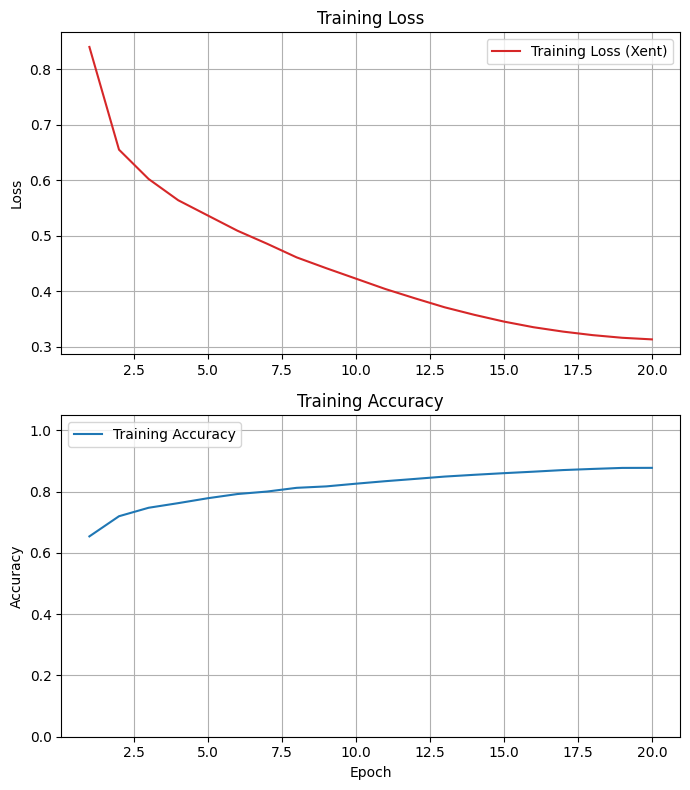

Final Training Loss:     0.3132
Final Training Accuracy: 0.8777

===== CosineDecay with initial_learning_rate = 0.001 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5982 - loss: 1.0224
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7016 - loss: 0.7262
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7276 - loss: 0.6553
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7409 - loss: 0.6138
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7551 - loss: 0.5844
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7657 - loss: 0.5626
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7769 - loss: 0.5448
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7839 - loss: 0.5301
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7895 - loss: 0.5175
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7942 - loss: 0.5071
Epoch 11/20
481

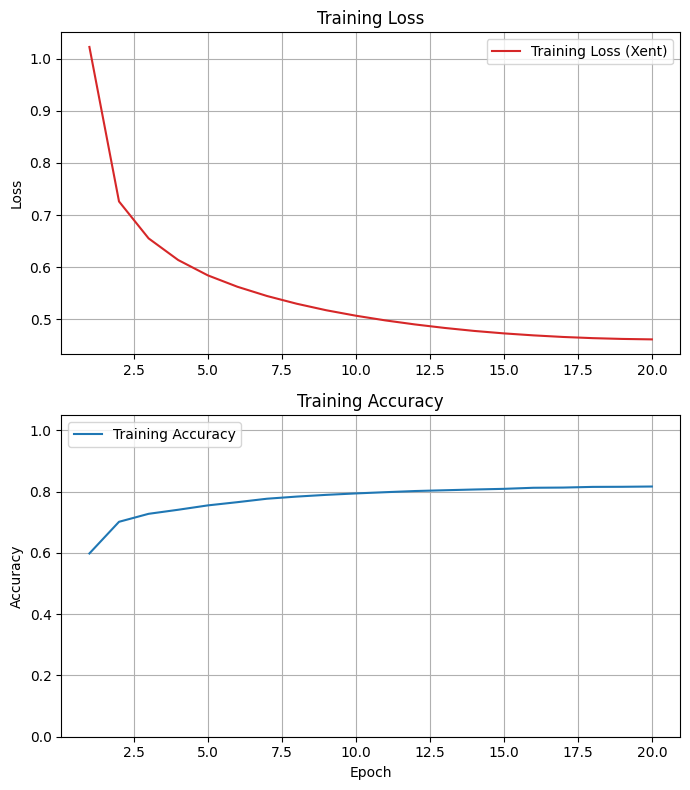

Final Training Loss:     0.4617
Final Training Accuracy: 0.8167

===== CosineDecay with initial_learning_rate = 0.0005 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5399 - loss: 1.1959
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6598 - loss: 0.8291
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6936 - loss: 0.7499
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7168 - loss: 0.6998
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7298 - loss: 0.6637
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7409 - loss: 0.6369
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7490 - loss: 0.6165
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7562 - loss: 0.6003
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7617 - loss: 0.5875
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7662 - loss: 0.5773
Epoch 11/20
48

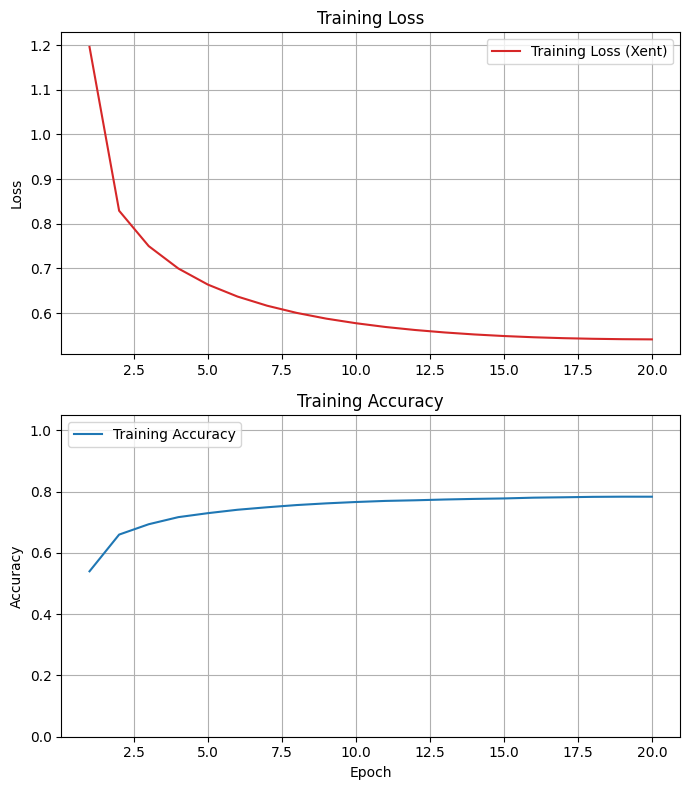

Final Training Loss:     0.5411
Final Training Accuracy: 0.7835

===== CosineDecay with initial_learning_rate = 0.0001 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3395 - loss: 1.7595
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5563 - loss: 1.2785
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6076 - loss: 1.0463
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6313 - loss: 0.9372
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6501 - loss: 0.8784
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6650 - loss: 0.8421
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6756 - loss: 0.8174
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6837 - loss: 0.7992
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6882 - loss: 0.7850
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6919 - loss: 0.7737
Epoch 11/20
48

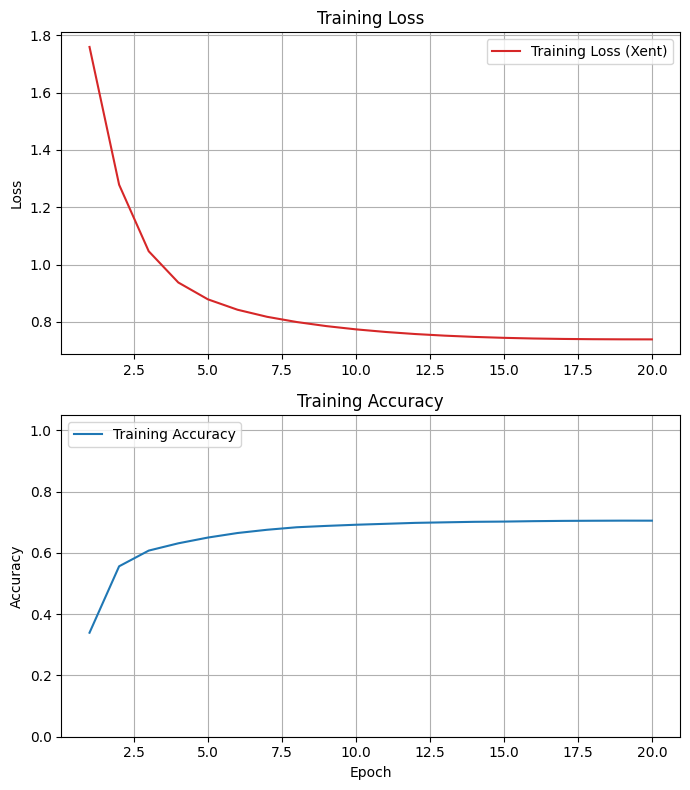

Final Training Loss:     0.7387
Final Training Accuracy: 0.7053


In [20]:
# Your code here

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

initial_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
epochs = 20
batch_size = 32  

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
decay_steps = steps_per_epoch * epochs

cos_histories = {}

for init_lr in initial_lrs:
    tf.keras.backend.clear_session()

    # Cosine decay schedule
    lr_schedule = CosineDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps
    )

    # Build baseline model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile with Adam using the schedule
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n===== CosineDecay with initial_learning_rate = {init_lr} =====")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    cos_histories[init_lr] = history
    plot_history(history)


In [21]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = 1e-2 

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [23]:
# Set a4b to the best accuracy found

a4b = 0.8858 

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8858


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6250 - loss: 0.9062
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6740 - loss: 0.7739
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6921 - loss: 0.7408
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7069 - loss: 0.7234
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7163 - loss: 0.6862
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7307 - loss: 0.6605
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7385 - loss: 0.6406
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7488 - loss: 0.6177
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7578 - loss: 0.5933
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7701 - loss: 0.5692
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7812 - loss: 0.5426
Epoch 12/20
3846/3846 ━━━━━━━━

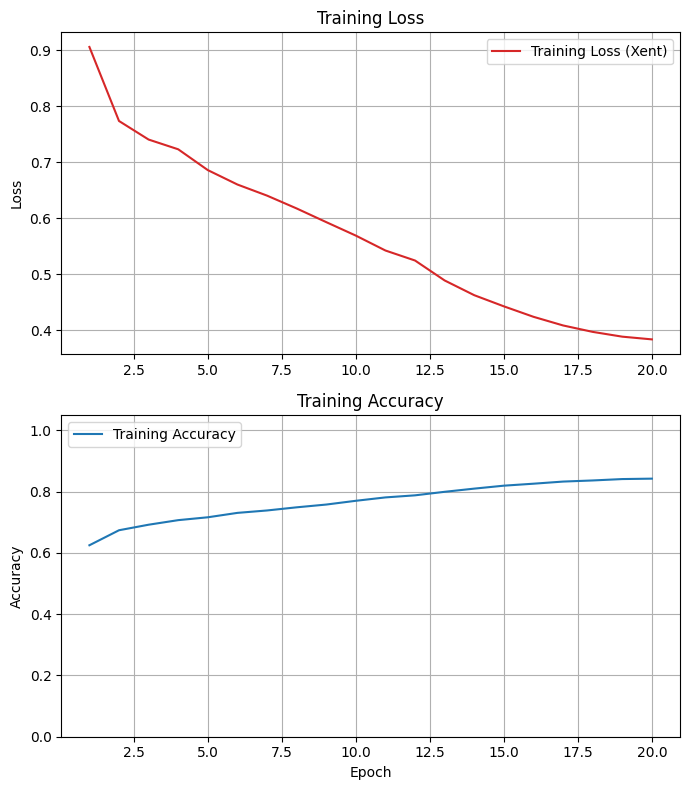

Final Training Loss:     0.3838
Final Training Accuracy: 0.8424
Test Loss: 0.5054
Test Accuracy: 0.8107


In [25]:
# Your code here -- add as many cells as you need

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

# Best hyperparams from your experiments
best_batch_size = 4
best_init_lr = 1e-2
epochs = 20

# decay_steps = steps_per_epoch * epochs
steps_per_epoch = int(np.ceil(len(X_train) / best_batch_size))
decay_steps = steps_per_epoch * epochs

lr_schedule = CosineDecay(
    initial_learning_rate=best_init_lr,
    decay_steps=decay_steps
)

tf.keras.backend.clear_session()

# SAME architecture as required: input -> 64 -> 32 -> 7
best_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

best_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_best = best_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=best_batch_size,
    verbose=1
)

# Plot training curves
plot_history(history_best)

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}") 


In [26]:
# Set a5a to the best training accuracy found by your best model

a5a = 4

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 4.0000


In [28]:
# Set a5b to the test accuracy found by your best model

a5b = 0.8162

In [29]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8162


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

   Because training time would go up since there’s more data per epoch. The best batch size might get a little bigger because the gradients are more stable with more data. The best learning rate could also be slightly higher (or use cosine decay) since updates are less noisy with a larger dataset.

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

   Smaller batches add more noise to updates, which actually helps generalization on tabular data. Big batches are smoother but can overfit or get stuck in sharper minima. If I had to use a big batch, I’d bump the learning rate, use a scheduler like cosine decay, and add a bit more regularization.

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

    Training loss would keep going down and training accuracy would go up, but test accuracy would probably level off or drop a bit from overfitting.

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

   Kind of, but not totally. From the experiments, a bad learning rate didn’t get fixed just by running more epochs. Picking a good learning rate (or using cosine decay) mattered more for getting good results fast.

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


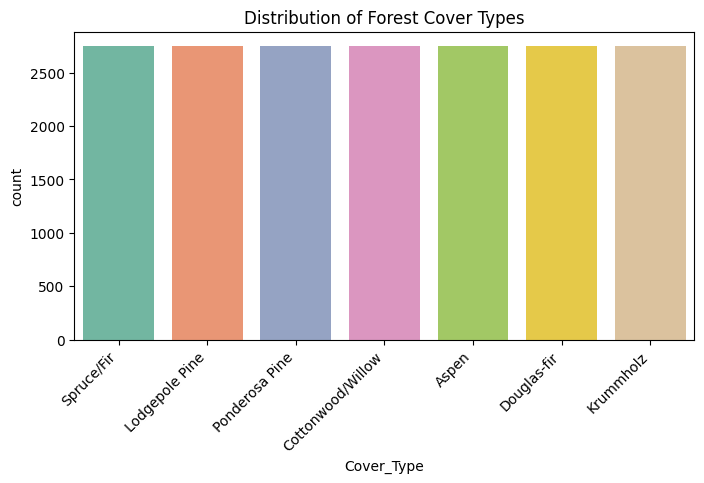

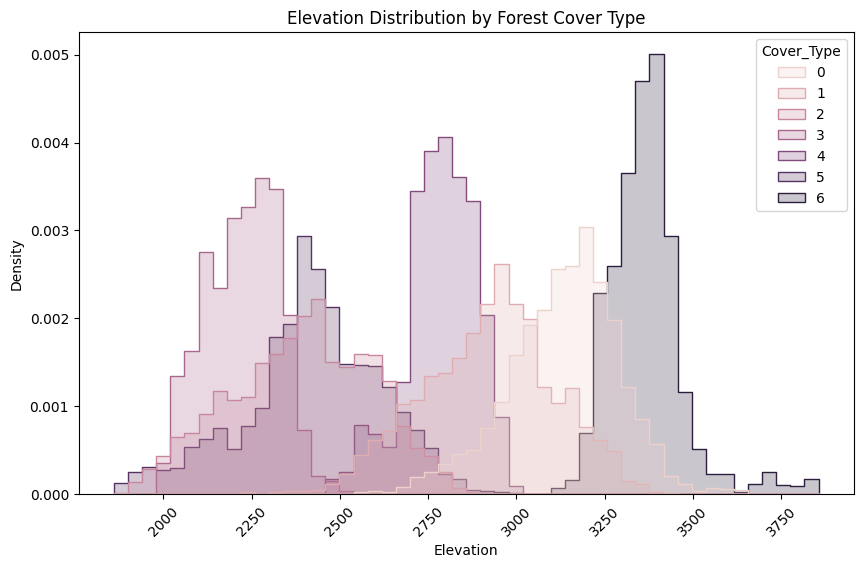

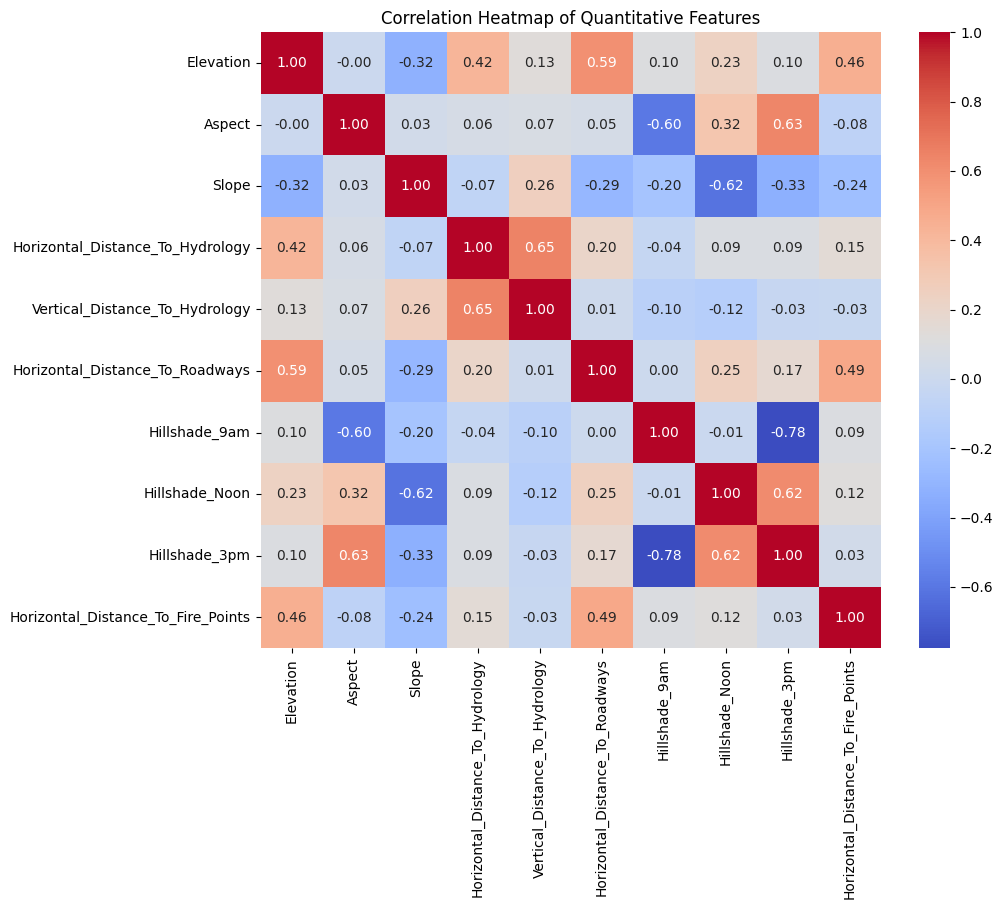

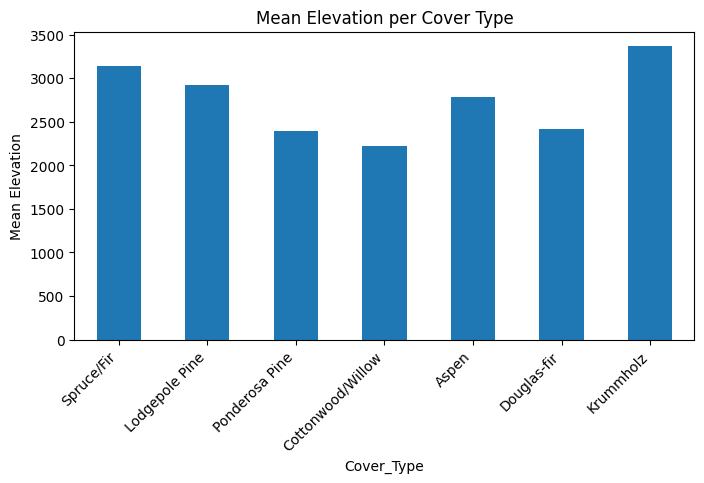

In [30]:
# Attach feature + class names

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show() 
